In [58]:
import os
import numpy as np

from scipy import interpolate
from scipy import optimize
import scipy
from scipy import sparse
from scipy.sparse.linalg import spsolve

import datetime

from astropy import coordinates as coord
from astropy import units as u
from astropy import constants as const
from astropy import time as astrotime
from astropy.coordinates import Angle

from matplotlib import pyplot as plt
from math import pi

In [76]:
class Transit:
    def __init__(self, date, dec_L, dec_mid, dec_R, horn, noon):
        self.date = date
        self.dec_mid = dec_mid
        self.dec_L = dec_L
        self.dec_R = dec_R
        self.horn = horn
        self.noon = noon
    def get_data(self):
        folder = os.path.join(f"data/{self.date}")
        #print(os.listdir(folder))
        datetimes = np.load(os.path.join(folder, 'datetimes.npy'), allow_pickle=True)
        a1p1 = np.load(os.path.join(folder, 'a1p1_bandpass.npy'), allow_pickle=True)
        a1p2 = np.load(os.path.join(folder, 'a1p2_bandpass.npy'), allow_pickle=True)
        a2p1 = np.load(os.path.join(folder, 'a2p1_bandpass.npy'), allow_pickle=True)
        a2p2 = np.load(os.path.join(folder, 'a2p2_bandpass.npy'), allow_pickle=True)
        power_array = np.stack((a2p1, a1p2, a1p1, a2p2))

        # a1p1, a2p2 = WEST, a1p2, a2p1 = EAST

        return datetimes, power_array

In [60]:
sc_transit = np.load(os.path.join('C:/Users/w82312eh', 'bandpass_powers_20240718.npy'), allow_pickle=True)
print(sc_transit.shape)

(10799000, 100)


In [61]:
sc_pwr_mins = np.empty((179,100))

for i in range(100):
    sc_pwr_ms = sc_transit[:,i][0:10740000]
    sc_pwr_mins[:,i] = np.sum(sc_pwr_ms.reshape(179,60000), axis=1)

In [62]:
def gaussian_with_baseline(x, a, b, c, d, m):
    return a*np.exp(-((x-b)**2)/(2*(c/(2*np.sqrt(2*np.log(2))))**2)) + m*x + d

def gaussian_with_baseline_fitting(x, y):
    p0 = np.array([np.max(y), x[np.argmax(y)], 23, 0, 0])
    popt, pcov = scipy.optimize.curve_fit(gaussian_with_baseline, x, y, absolute_sigma=0, p0=p0)
    #absolute_sigma=0 to ensure uncertainties reflect the fitting
    return popt, pcov

def line_fitting(x_data, y_data, y_uncertainties):

    weights = 1. / y_uncertainties**2
    repeated_term = (np.sum(weights) * np.sum(x_data**2 * weights) - np.sum(x_data * weights)**2)

    slope = ((np.sum(weights) * np.sum(x_data * y_data * weights) - np.sum(x_data * weights) * np.sum(y_data * weights)) / repeated_term)
    slope_uncertainty = np.sqrt(np.sum(weights) / repeated_term)

    offset = ((np.sum(y_data * weights) * np.sum(x_data**2 * weights) - np.sum(x_data * weights) * np.sum(x_data * y_data * weights)) / repeated_term)
    offset_uncertainty = np.sqrt(np.sum(x_data**2 * weights) / repeated_term)

    return (np.array([slope, offset]), np.array([slope_uncertainty, offset_uncertainty]))

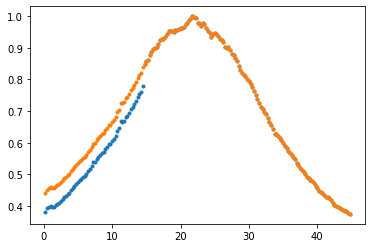

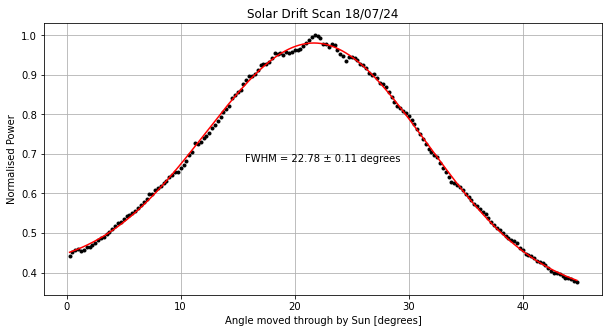

In [69]:
angle = np.linspace(1,179,179) * 360/(60*24)

tot_sc_pwr = np.sum(sc_pwr_mins, axis=1)/np.max(np.sum(sc_pwr_mins, axis=1))
plt.plot(angle, tot_sc_pwr, ".")

tot_sc_pwr = np.append(tot_sc_pwr[:58] + 0.06,tot_sc_pwr[58:])
plt.plot(angle, tot_sc_pwr, ".")

#popt, pcov = gaussian_with_baseline_fitting(angle[58:], tot_sc_pwr[58:])
popt, pcov = gaussian_with_baseline_fitting(angle, tot_sc_pwr)

fwhm = popt[2]
fwhm_error = np.sqrt(np.diag(pcov)[2])

plt.figure(figsize=(10, 5))
plt.plot(angle, tot_sc_pwr, "k.")
plt.plot(np.linspace(np.min(angle), np.max(angle), 1000), gaussian_with_baseline(np.linspace(np.min(angle), np.max(angle), 1000), *popt), "r")
plt.xlabel('Angle moved through by Sun [degrees]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.title("Solar Drift Scan 18/07/24")
plt.annotate(f"FWHM = {fwhm:.2f} ± {fwhm_error:.2f} degrees", (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
plt.show()

(4, 420, 718) (420,)


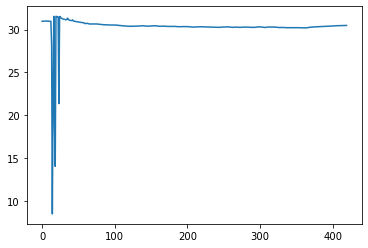

In [103]:
lb_transit = Transit('18th July 2024', 0, 20.873053993789906, 0, 'E', datetime.datetime(2024, 7, 18, 12, 15, 30))
lb_time, lb_pwr = lb_transit.get_data()
print(lb_pwr.shape, lb_time.shape)
lb_pwr_tot = np.average(lb_pwr[0,:,112:567], axis=1)
plt.plot(lb_pwr_tot)